In [43]:
!pip install openml --quiet
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVR
import openml
from gradient_descent import GDRegressor
from knn import KNNRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import time

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [45]:
#Importing dataset from openml
diamonds = openml.datasets.get_dataset(42225)

C:\Users\admin\AppData\Local\Temp\ipykernel_14544\795755477.py:2: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  diamonds = openml.datasets.get_dataset(42225)


In [46]:
X, y, categorical_indicator, attribute_names = diamonds.get_data(
    target=diamonds.default_target_attribute,
    dataset_format='dataframe'
)

X.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75


In [47]:
#Checking for missing values
X.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
dtype: int64

In [48]:
#Checking for missing values
y.isnull().sum()

0

In [49]:
#Checking the distribution of the target variable
y.value_counts()

price
605      132
802      127
625      126
828      125
776      124
        ... 
8816       1
14704      1
14699      1
14698      1
9793       1
Name: count, Length: 11602, dtype: int64

In [50]:
if 'price' in X.columns:
    X = X.drop('price', axis=1)

In [51]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#List of models
models = [GDRegressor(learning_rate=0.1, max_iter=1000), SGDRegressor(), RandomForestRegressor(), KNNRegressor(), KNeighborsRegressor(n_neighbors=3), SVR()]

for model in models:
    #Initializing lists to store scores for each model
    rmse_scores = []
    r2_scores = []
    times = []

    for train_index, test_index in kf.split(X):
        #Split the data
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        #Reset the indices
        X_train.reset_index(drop=True, inplace=True)
        X_test.reset_index(drop=True, inplace=True)
        y_train.reset_index(drop=True, inplace=True)
        y_test.reset_index(drop=True, inplace=True)
        
        #Preprocess the data
        le = LabelEncoder()
        for column in ['cut', 'color', 'clarity']:
            X_train[column] = le.fit_transform(X_train[column])
            X_test[column] = le.transform(X_test[column])

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        #Training the model
        start_time = time.time()
        model.fit(X_train_scaled, y_train)
        end_time = time.time()

        predictions = model.predict(X_test_scaled)
        if isinstance(model, KNNRegressor):
            knn_predictions = predictions
        if isinstance(model, SGDRegressor):
            sgd_predictions = predictions
        if isinstance(model, KNeighborsRegressor):
            knn_sklearn_predictions = predictions

        #Calculating scores
        rmse = mean_squared_error(y_test, predictions, squared=False)
        r2 = r2_score(y_test, predictions)

        rmse_scores.append(rmse)
        r2_scores.append(r2)
        times.append(end_time - start_time)

    #Calculating average scores
    average_rmse = np.mean(rmse_scores)
    average_r2 = np.mean(r2_scores)
    average_time = np.mean(times)

    print(f"Model: {model.__class__.__name__}")
    print(f"Average RMSE: {average_rmse}")
    print(f"Average R2: {average_r2}")
    print(f"Average Time: {average_time} seconds")

Model: GDRegressor
Average RMSE: 1357.1541936221936
Average R2: 0.8842181353756595
Average Time: 2.2902095794677733 seconds
Model: SGDRegressor
Average RMSE: 1355.5167530712558
Average R2: 0.8845022086684514
Average Time: 0.07877573966979981 seconds
Model: RandomForestRegressor
Average RMSE: 548.2446300961893
Average R2: 0.9811037547173935
Average Time: 25.975080251693726 seconds
Model: KNNRegressor
Average RMSE: 926.38891439862
Average R2: 0.9460293587433076
Average Time: 0.011804723739624023 seconds
Model: KNeighborsRegressor
Average RMSE: 829.2758438000858
Average R2: 0.956718786001613
Average Time: 0.09719161987304688 seconds
Model: SVR
Average RMSE: 2782.3398237183765
Average R2: 0.5135460791626725
Average Time: 62.66274280548096 seconds


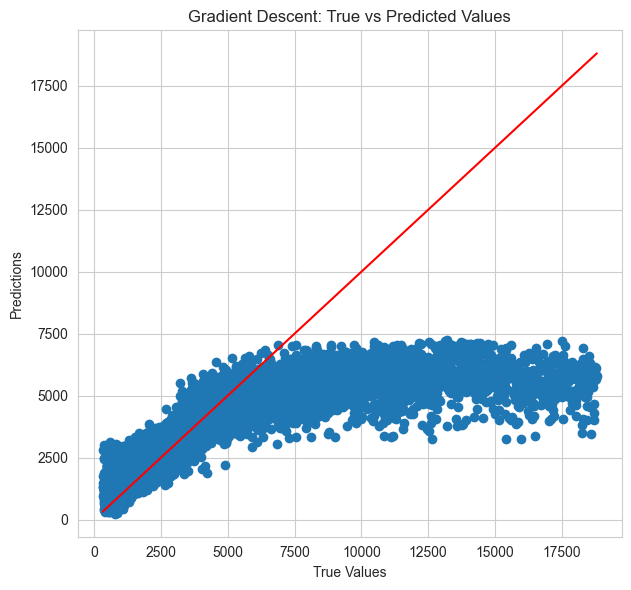

In [52]:
plt.figure(figsize=(12, 6))

#Scatter plot for Gradient Descent predictions
plt.subplot(1, 2, 1)
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Gradient Descent: True vs Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.tight_layout()
plt.show()

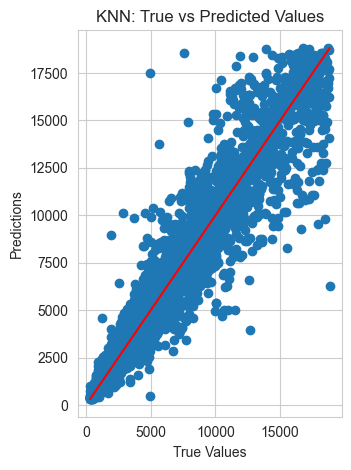

In [53]:
#Scatter plot for KNN predictions
plt.subplot(1, 2, 2)
plt.scatter(y_test, knn_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('KNN: True vs Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.tight_layout()
plt.show()

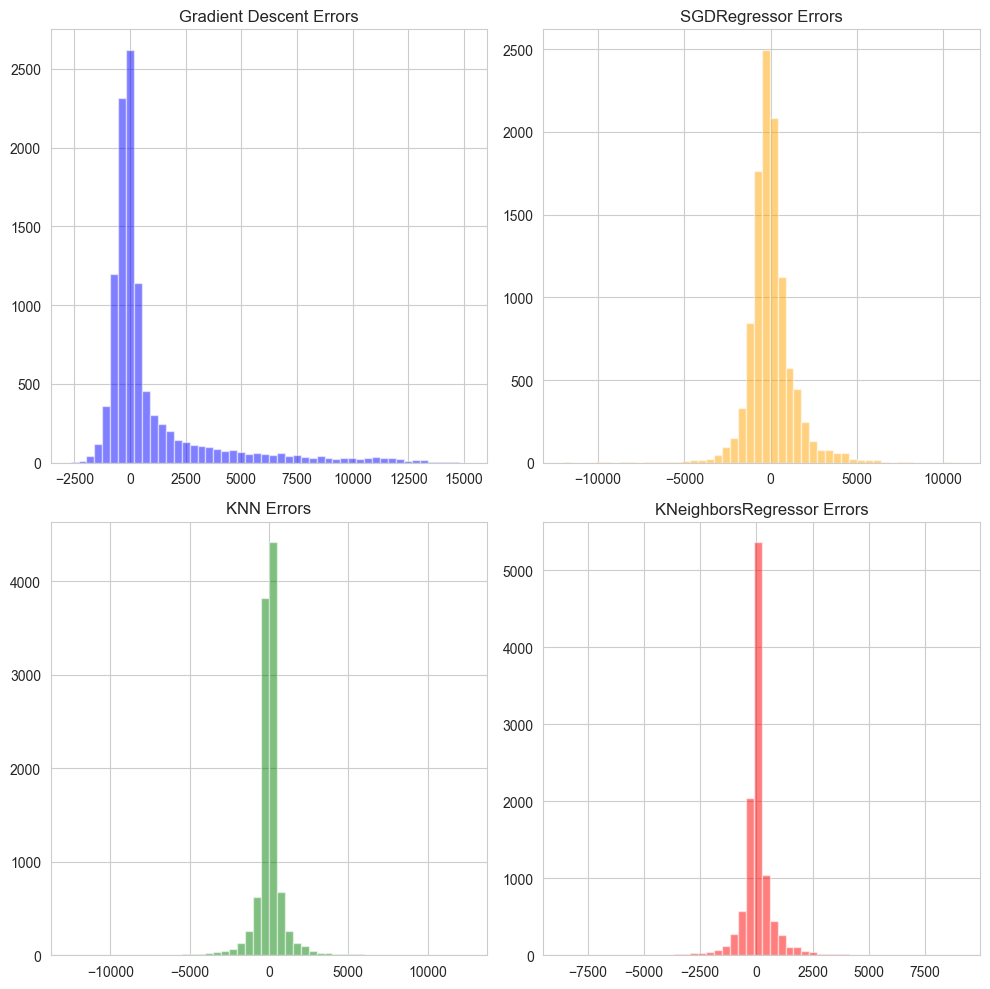

In [54]:
#Calculating errors
gd_errors = y_test - predictions
sgd_errors = y_test - sgd_predictions
knn_errors = y_test - knn_predictions
knn_sklearn_errors = y_test - knn_sklearn_predictions

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

#Plot errors for Gradient Descent
axs[0, 0].hist(gd_errors, bins=50, color='blue', alpha=0.5)
axs[0, 0].set_title('Gradient Descent Errors')

#Plot errors for SGDRegressor
axs[0, 1].hist(sgd_errors, bins=50, color='orange', alpha=0.5)
axs[0, 1].set_title('SGDRegressor Errors')

#Plot errors for KNN
axs[1, 0].hist(knn_errors, bins=50, color='green', alpha=0.5)
axs[1, 0].set_title('KNN Errors')

#Plot errors for KNeighborsRegressor
axs[1, 1].hist(knn_sklearn_errors, bins=50, color='red', alpha=0.5)
axs[1, 1].set_title('KNeighborsRegressor Errors')

plt.tight_layout()
plt.show()